In [1]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn

/usr/local/pkg/python/2.7.12/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/usr/local/pkg/python/2.7.12/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import theano
import theano.tensor as T
import numpy as np

Using gpu device 0: Tesla K20Xm (CNMeM is disabled, cuDNN not available)


In [3]:
from models.special import Psi

In [4]:
logbeta_ = T.matrix()
probs = T.nnet.softmax(logbeta_)
logprobs = T.log(probs)
KL_Y = T.sum(probs*logprobs,axis=1) + T.log(logbeta_.shape[1])
grad_KL_Y = T.grad(KL_Y.sum(),logbeta_)
f_exactM2 = theano.function([logbeta_],[grad_KL_Y,KL_Y],allow_input_downcast=True)

In [5]:
logbeta_ = T.matrix()
beta_ = T.exp(logbeta_)
betaprior = np.exp(-2)
KL_alpha = (T.gammaln(betaprior)-T.gammaln(beta_)-(betaprior-beta_)*Psi()(beta_)).sum(1,keepdims=True)
grad_KL_alpha = T.grad(KL_alpha.sum(),logbeta_)
f_Dirichlet = theano.function([logbeta_],[grad_KL_alpha,KL_alpha],allow_input_downcast=True)

In [6]:
mu_ = T.matrix()
logcov=0.
KL_gaussian = 0.5*T.sum(-logcov -1 + T.exp(logcov) +mu_**2 ,axis=1,keepdims=True)
grad_KL_gaussian = T.grad(KL_gaussian.sum(),mu_)
f_gaussian = theano.function([mu_],[grad_KL_gaussian,KL_gaussian],allow_input_downcast=True)

In [7]:
mu_ = T.matrix()
KL_gumbelsoftmax = T.sum(-1. + mu_ + T.exp(-mu_),axis=1)
grad_KL_gumbelsoftmax = T.grad(KL_gumbelsoftmax.sum(),mu_)
f_gumbelsoftmax = theano.function([mu_],[grad_KL_gumbelsoftmax,KL_gumbelsoftmax],allow_input_downcast=True)

In [8]:
def _LogBetaFunction(beta,**kwargs):
    return T.sum(T.gammaln(beta),**kwargs)-T.gammaln(beta.sum(**kwargs))

def _DirichletNegCrossEntropy(beta_q,beta_p):
    """
        KL divergence D(q||p)
        where q and p are dirichlet with parameters beta_q and beta_p, respectively
    """
    logB = _LogBetaFunction(beta_p,axis=1,keepdims=True)
    return -logB + T.sum((beta_p-1)*(Psi()(beta_q)-Psi()(beta_q.sum(axis=1,keepdims=True))),axis=1,keepdims=True)

def _KL_Dirichlet(beta_q,beta_p):
    """
        Compute E_{q(alpha|beta_q)}[logq(alpha|beta_q)-logp(alpha|beta_p)]
    """
    qlogq = _DirichletNegCrossEntropy(beta_q,beta_q)
    qlogp = _DirichletNegCrossEntropy(beta_q,beta_p)
    return qlogq-qlogp

logbeta_ = T.matrix()
beta_ = T.exp(logbeta_)
betaprior = np.exp(-2)*np.ones((1,10))
KL_alpha = _KL_Dirichlet(beta_,betaprior)
grad_KL_alpha = T.grad(KL_alpha.sum(),logbeta_)
f_Dirichlet2 = theano.function([logbeta_],[grad_KL_alpha,KL_alpha],allow_input_downcast=True)

In [9]:
logbeta_ = T.matrix()
probs = T.nnet.softmax(logbeta_)
check = theano.function([logbeta_],[probs],allow_input_downcast=True)

In [10]:
logbeta = np.log(0.2)*np.ones((20,10))
#logbeta[:,-1] = np.arange(-10,20,1.5)
logbeta[:,-1] = np.arange(0.1,10.1,.5)
g_exactM2, F_exactM2 = f_exactM2(logbeta)

<function matplotlib.pyplot.xscale>

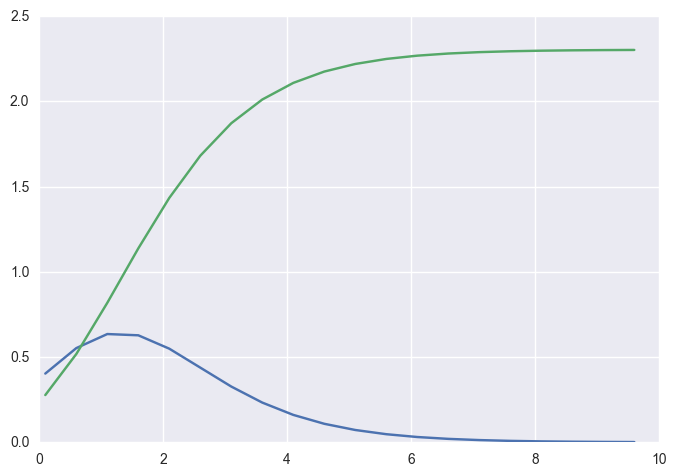

In [11]:
plt.plot(logbeta[:,-1],g_exactM2[:,-1])
plt.plot(logbeta[:,-1],F_exactM2.ravel())
plt.xscale

In [12]:
g_Dirichlet, F_Dirichlet = f_Dirichlet(logbeta)

In [13]:
g_gaussian, F_gaussian = f_gaussian(logbeta)

In [14]:
g_Dirichlet2, F_Dirichlet2 = f_Dirichlet2(logbeta)

In [20]:
logbeta = np.zeros((20,10))
logbeta[:,-1] = np.arange(-1.,9,.5)
g_gaussian, F_gaussian = f_gaussian(logbeta)

In [21]:
g_gumbel, F_gumbel = f_gumbelsoftmax(logbeta)

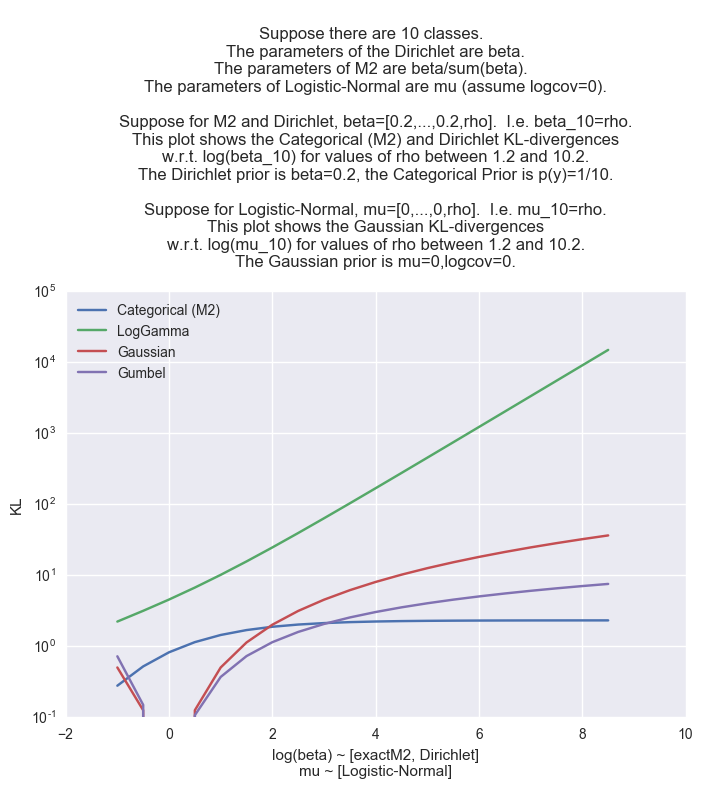

In [22]:
plt.plot(logbeta[:,-1],F_exactM2.ravel(),label='Categorical (M2)')
plt.plot(logbeta[:,-1],F_Dirichlet.ravel(),label='LogGamma')
#plt.plot(logbeta[:,-1],F_Dirichlet2.ravel(),label='Dirichlet2')
plt.plot(logbeta[:,-1],F_gaussian.ravel(),label='Gaussian')
plt.plot(logbeta[:,-1],F_gumbel.ravel(),label='Gumbel')
plt.yscale('log')
plt.legend(loc='upper left')
#plt.title('grad KL w.r.t.\nlog(beta) [exactM2, Dirichlet]\nmu [Logistic-Normal]')
plt.title("""
Suppose there are 10 classes.  
The parameters of the Dirichlet are beta.
The parameters of M2 are beta/sum(beta).  
The parameters of Logistic-Normal are mu (assume logcov=0).

Suppose for M2 and Dirichlet, beta=[0.2,...,0.2,rho].  I.e. beta_10=rho.
This plot shows the Categorical (M2) and Dirichlet KL-divergences
w.r.t. log(beta_10) for values of rho between 1.2 and 10.2.
The Dirichlet prior is beta=0.2, the Categorical Prior is p(y)=1/10.

Suppose for Logistic-Normal, mu=[0,...,0,rho].  I.e. mu_10=rho.
This plot shows the Gaussian KL-divergences
w.r.t. log(mu_10) for values of rho between 1.2 and 10.2.
The Gaussian prior is mu=0,logcov=0.
""")
plt.ylabel('KL')
plt.xlabel('log(beta) ~ [exactM2, Dirichlet]\nmu ~ [Logistic-Normal]')

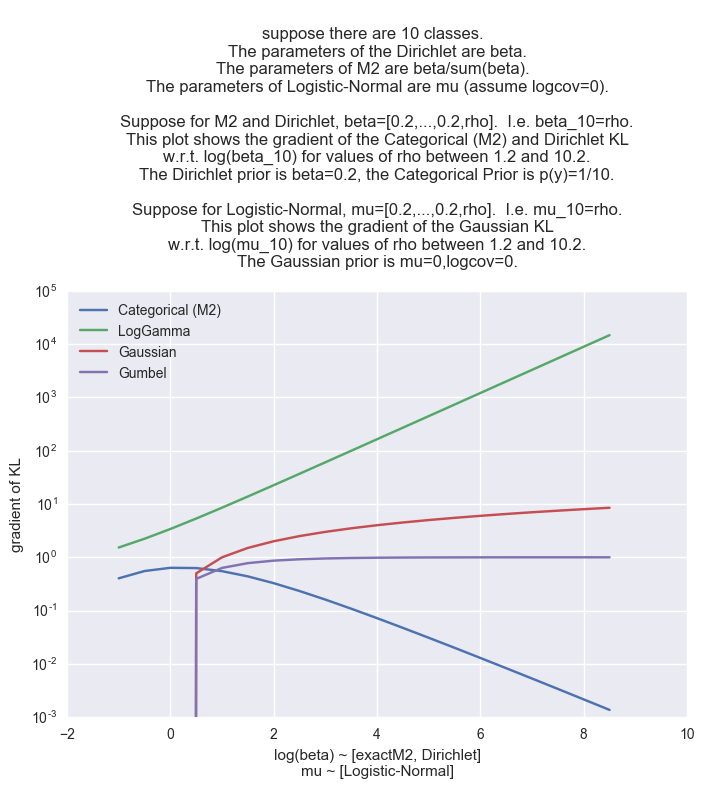

In [23]:
plt.plot(logbeta[:,-1],g_exactM2[:,-1],label='Categorical (M2)')
plt.plot(logbeta[:,-1],g_Dirichlet[:,-1],label='LogGamma')
#plt.plot(logbeta[:,-1],g_Dirichlet2[:,-1],label='Dirichlet')
plt.plot(logbeta[:,-1],g_gaussian[:,-1],label='Gaussian')
plt.plot(logbeta[:,-1],g_gumbel[:,-1],label='Gumbel')
plt.yscale('log')
plt.legend(loc='upper left')
#plt.title('grad KL w.r.t.\nlog(beta) [exactM2, Dirichlet]\nmu [Logistic-Normal]')
plt.title("""
suppose there are 10 classes.  
The parameters of the Dirichlet are beta.
The parameters of M2 are beta/sum(beta).  
The parameters of Logistic-Normal are mu (assume logcov=0).

Suppose for M2 and Dirichlet, beta=[0.2,...,0.2,rho].  I.e. beta_10=rho.
This plot shows the gradient of the Categorical (M2) and Dirichlet KL
w.r.t. log(beta_10) for values of rho between 1.2 and 10.2.
The Dirichlet prior is beta=0.2, the Categorical Prior is p(y)=1/10.

Suppose for Logistic-Normal, mu=[0.2,...,0.2,rho].  I.e. mu_10=rho.
This plot shows the gradient of the Gaussian KL
w.r.t. log(mu_10) for values of rho between 1.2 and 10.2.
The Gaussian prior is mu=0,logcov=0.
""")
plt.ylabel('gradient of KL')
plt.xlabel('log(beta) ~ [exactM2, Dirichlet]\nmu ~ [Logistic-Normal]')